In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

In [2]:
TRAINING_FEATURES_PATH=r"C:\Users\pavan\OneDrive\Desktop\training_set_features.csv"
TRAINING_LABELS_PATH=r"C:\Users\pavan\OneDrive\Desktop\training_set_labels.csv"
TEST_FEATURES_PATH=r"C:\Users\pavan\OneDrive\Desktop\test_set_features.csv"


In [3]:
features_df= pd.read_csv(TRAINING_FEATURES_PATH,index_col='respondent_id')
labels_df= pd.read_csv(TRAINING_LABELS_PATH,index_col='respondent_id')
test_features_df= pd.read_csv(TEST_FEATURES_PATH,index_col="respondent_id")

In [4]:
train_data = features_df.join(labels_df)
train_data.head()

,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [5]:
train_data.isna().sum().sort_values(ascending=False)/len(train_data)

employment_occupation          0.504362
employment_industry            0.499120
health_insurance               0.459580
income_poverty                 0.165612
doctor_recc_xyz                0.080878
doctor_recc_seasonal           0.080878
rent_or_own                    0.076459
employment_status              0.054780
marital_status                 0.052720
education                      0.052683
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
opinion_seas_sick_from_vacc    0.020107
opinion_seas_risk              0.019246
opinion_seas_vacc_effective    0.017299
opinion_xyz_sick_from_vacc     0.014790
opinion_xyz_vacc_effective     0.014640
opinion_xyz_risk               0.014528
household_adults               0.009323
household_children             0.009323
behavioral_avoidance           0.007788
behavioral_touch_face          0.004793
xyz_knowledge                  0.004343
xyz_concern                    0.003445


In [6]:
def data_encoding(data):
    data['sex'] = data['sex'].replace({'Male': 0, 'Female': 1})
    data['marital_status'] = data['marital_status'].replace({'Not Married': 0, 'Married': 1})
    data['rent_or_own'] = data['rent_or_own'].replace({'Rent': 0, 'Own': 1})

    data['age_group'] = data['age_group'].replace({'18 - 34 Years': 0,'35 - 44 Years': 1,'45 - 54 Years': 2,'55 - 64 Years': 3,
                                                   '65+ Years': 4 })

    data['education'] = data['education'].replace({'< 12 Years': 0,'12 Years': 1,'Some College': 2,'College Graduate': 3
    })

    data['income_poverty'] = data['income_poverty'].replace({'Below Poverty': 0,'<= $75,000, Above Poverty': 1,'> $75,000': 2
    })

    data['employment_status'] = data['employment_status'].replace({'Not in Labor Force': 0, 'Unemployed': 1,'Employed': 2
    })

    data['census_msa'] = data['census_msa'].replace({'Non-MSA': 0,'MSA, Not Principle  City': 1,'MSA, Principle City': 2
    })

    # Define the columns to be one hot encoded
    columns_to_encode = ['race', 'hhs_geo_region', 'employment_industry', 'employment_occupation']
    encoder = OneHotEncoder(sparse=False)

    encoded_columns = encoder.fit_transform(data[columns_to_encode])
    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
    encoded_df.index = data.index
    data_encoded = pd.concat([data, encoded_df], axis=1)
    
    data_encoded.drop(columns_to_encode, axis=1, inplace=True)
    
    return data_encoded

In [7]:
train_data_encoded = data_encoding(train_data)
train_data_encoded


C:\Users\pavan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,employment_occupation_nan
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
train_data_reencoded = pd.get_dummies(train_data_encoded, columns=train_data_encoded.columns[train_data_encoded.isna().any()], dummy_na=True)

train_data_reencoded.shape

(26707, 178)

In [9]:
train_data_reencoded2 = train_data_reencoded.drop(columns=[col for col in train_data_reencoded.columns if "_nan" in col])


In [10]:
for i in train_data_reencoded2.columns:
    print(i)
    
train_data_reencoded2.shape

age_group
sex
census_msa
xyz_vaccine
seasonal_vaccine
race_Black
race_Hispanic
race_Other or Multiple
race_White
hhs_geo_region_atmpeygn
hhs_geo_region_bhuqouqj
hhs_geo_region_dqpwygqj
hhs_geo_region_fpwskwrf
hhs_geo_region_kbazzjca
hhs_geo_region_lrircsnp
hhs_geo_region_lzgpxyit
hhs_geo_region_mlyzmhmf
hhs_geo_region_oxchjgsf
hhs_geo_region_qufhixun
employment_industry_arjwrbjb
employment_industry_atmlpfrs
employment_industry_cfqqtusy
employment_industry_dotnnunm
employment_industry_fcxhlnwr
employment_industry_haxffmxo
employment_industry_ldnlellj
employment_industry_mcubkhph
employment_industry_mfikgejo
employment_industry_msuufmds
employment_industry_nduyfdeo
employment_industry_phxvnwax
employment_industry_pxcmvdjn
employment_industry_qnlwzans
employment_industry_rucpziij
employment_industry_saaquncn
employment_industry_vjjrobsf
employment_industry_wlfvacwt
employment_industry_wxleyezf
employment_industry_xicduogh
employment_industry_xqicxuve
employment_occupation_bxpfxfdn
employm

(26707, 148)

In [11]:
X = train_data_reencoded.drop(columns=['xyz_vaccine','seasonal_vaccine'], axis=1)
y = train_data_reencoded[['xyz_vaccine']]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=1)

In [12]:
sv = svm.SVC(kernel='linear',C=1.0,probability=True)
sv.fit(X_train,y_train.values.ravel())

SVC(kernel='linear', probability=True)

In [13]:
pred=sv.predict(X_test)

In [14]:
print(accuracy_score(y_test,pred))

0.8530777295192452


In [15]:
def draw_roc_curve(test, pred_proba):
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(test, pred_proba)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return roc_auc_score(test, pred_proba)

In [17]:
prob1=sv.predict_proba(X_test)

In [22]:
fpr1, tpr1, thresh1 = roc_curve(y_test,prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [21]:
auc_score = roc_auc_score(y_test,prob1[:,1])
auc_score

0.8643634010096632

C:\Users\pavan\AppData\Local\Temp\ipykernel_19836\3549286189.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


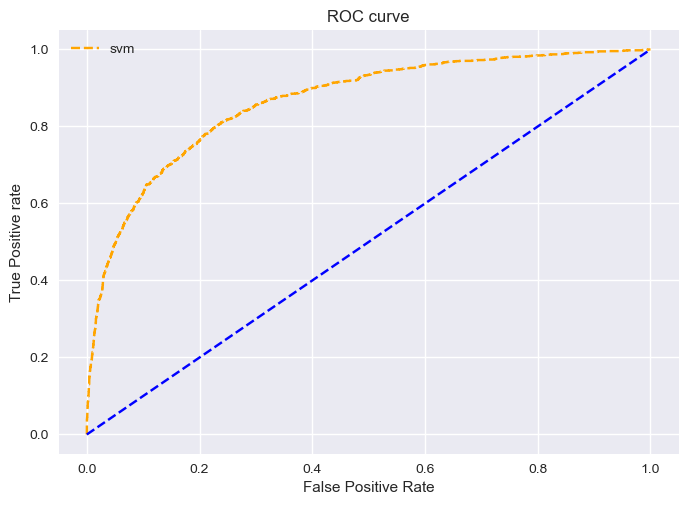

In [23]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='svm')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [24]:
X = train_data_reencoded.drop(columns=['xyz_vaccine','seasonal_vaccine'], axis=1)
y = train_data_reencoded[['seasonal_vaccine']]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=1)

In [ ]:
svc = svm.SVC(kernel='linear',C=1.0,probability=True)
svc.fit(X_train1,y_train1.values.ravel())

In [ ]:
pred1=sv.predict(X_test)

In [ ]:
print(accuracy_score(y_test1,pred1))

In [ ]:
prob1=sv.predict_proba(X_test1)

In [ ]:
fpr1, tpr1, thresh1 = roc_curve(y_test1,prob1[:,1], pos_label=1)
random_probs = [0 for i in range(len(y_test1))]
p_fpr, p_tpr, _ = roc_curve(y_test1, random_probs, pos_label=1)

In [ ]:
auc_score = roc_auc_score(y_test1,prob1[:,1])
auc_score